# Phishing Website Detection

## Project description:  
Using Natural Language Processing approch and by focusing on words in Adress Bar, a Neural Network has been traind to detect Phishing and legitimate website.`For this project a dataset, containing one million phishing and legitimate URL, has been used. 

##Project Repo:
https://github.com/anitasafi/Phishing-Website-Detection

##Participants:
Anita Safi, Manikwadura Dilini Tharindika, Awais Khan Malik, Razeeb Sarker

##Course and Semester:
Deep Learning from Scratch/SoSe2021

In [ ]:
!pip install selenium



     |████████████████████████████████| 911kB 4.3MB/s 


In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns  
import matplotlib.pyplot as plt 
%matplotlib inline 
import time  
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from nltk.tokenize import RegexpTokenizer   
from nltk.stem.snowball import SnowballStemmer 
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.pipeline import make_pipeline 
from PIL import Image 
from bs4 import BeautifulSoup 
from selenium import webdriver  
import networkx as nx 
import pickle 
import warnings  
warnings.filterwarnings('ignore')

# Data Collection 

For this approach, we have increased number of URLs to 1 million. Data collection was challenging because the main source for phishing URLs, Phishtank, has limited new accesses. So we had to find URLs from different sources. 
Since most of phishing attacks attemp to steal users private or financial informarmation, then a huge part of our focus was on finding phishing URLs that had targeted specific brands like paypal, amazon, and etc. 

AZSecure-data.org (https://www.azsecure-data.org/phishing-websites.html, which is a security and intelligence project by University of Arizona offered us a great part of our dataset. 

Combining what we had from before and what we collected from different sources, shaped a Dataset with more than 1 million fake and real URLs. 


In [ ]:
phishingandlegitimate_urls = pd.read_csv('phishingandlegitimate_urls.csv',usecols=['URL','Label'],encoding='latin1', error_bad_lines=False)
phishingandlegitimate_urls.columns = ['URL','Label']
phishing_urls1 = pd.read_csv('phishing_urls1.csv',usecols=['URL','Label'],encoding='latin1', error_bad_lines=False)
phishing_urls1.columns = ['URL','Label']
phishing_urls2 = pd.read_csv('phishing_urls2.csv',usecols=['URL','Label'],encoding='latin1', error_bad_lines=False)
phishing_urls2.columns = ['URL','Label']
legitimate_urls1 = pd.read_csv('legitimate_urls1.csv',usecols=['URL','Label'],encoding='latin1', error_bad_lines=False)
legitimate_urls1.columns = ['URL','Label']
legitimate_urls2 = pd.read_csv('legitimate_urls2.csv',usecols=['URL','Label'],encoding='latin1', error_bad_lines=False)
legitimate_urls2.columns = ['URL','Label']


In [ ]:
#merging datasets 

urls = pd.concat([phishingandlegitimate_urls, phishing_urls1, phishing_urls2, legitimate_urls1, legitimate_urls2 ]).reset_index(drop=True)
urls.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,phishing
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,phishing
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,phishing
3,mail.printakid.com/www.online.americanexpress....,phishing
4,thewhiskeydregs.com/wp-content/themes/widescre...,phishing


In [ ]:
#saving dataset
urls.to_csv(r'urls.csv', index = False)

In [ ]:
urls = pd.read_csv('urls.csv')
urls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091334 entries, 0 to 1091333
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   URL     1091334 non-null  object
 1   Label   1091334 non-null  object
dtypes: object(2)
memory usage: 16.7+ MB


In [ ]:
urls.isnull().sum()

URL      0
Label    0
dtype: int64

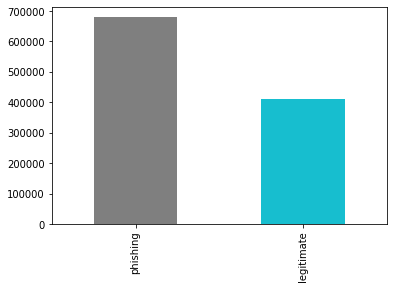

In [ ]:
#visualizing target_col
colors = ['#7f7f7f', '#17becf'] 
urls['Label'].value_counts().plot.bar(color = colors , figsize = (6, 4))

# Data Preprocessing

For the case of URLs, it does not make that much sense to analyse what kind of word or with what connotation they have been used in an URL. But what we seek to do is that the model learn 
1. the correct spelling of words, since many phishing URLs take advantage of misspelling words which look familiar to the eyes of users and makes it look credible at the first glance. 

2. how words are grouped together based on words and lenght of them.

As tokenizer Regular expression tokenizer has been used which splits a string into substrings using a regular expression which matches either the tokens or the separators between tokens. 

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def preprocess(urls):
    urls=str(urls)
    urls = urls.lower()
    urls=urls.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', urls)
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    tokens = tokenizer.tokenize(cleantext)  
    stem_words=[stemmer.stem(w) for w in tokens]
    return " ".join(tokens)
    



In [ ]:
urls['tokens']= urls['URL'].map(lambda s:preprocess(s)) 

In [ ]:
urls.sample(10)

,URL,Label,tokens
978961,http://clubyom.com/ticket/uploads/paypal.fr/,phishing,http clubyom com ticket uploads paypal fr
869176,http://www.particuliergp.com/chalada/dsfsdfezf...,phishing,http www particuliergp com chalada dsfsdfezfdg...
251800,twitter.com/mikewayne,legitimate,twitter com mikewayne
494963,be-stlines-tore.com/tr35esf,phishing,be stlines tore com tr esf
571390,http://lugiasicecream.com/PayPal/Login/c6bee17...,phishing,http lugiasicecream com paypal login c bee e d...
531245,www.amelander.nl/78h8ry,phishing,www amelander nl h ry
328066,facebook.com/mick.mcmanus,legitimate,facebook com mick mcmanus
235639,rockhall.com/inductees/bill-graham/,legitimate,rockhall com inductees bill graham
331198,facebook.com/people/Antony-Whitaker/1000006758...,legitimate,facebook com people antony whitaker
866166,http://stargrove00.netne.net/ebay.htm,phishing,http stargrove netne net ebay htm


In [ ]:
Legitimate = urls[urls.Label == 'legitimate']
Phishing = urls[urls.Label == 'phishing']

In [ ]:
Phishing.head()

,URL,Label,tokens
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,phishing,nobell it ffb d dca cce f login skype com en c...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,phishing,www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,phishing,serviciosbys com paypal cgi bin get into herf ...
3,mail.printakid.com/www.online.americanexpress....,phishing,mail printakid com www online americanexpress ...
4,thewhiskeydregs.com/wp-content/themes/widescre...,phishing,thewhiskeydregs com wp content themes widescre...


In [ ]:
Legitimate.head()

,URL,Label,tokens
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,legitimate,esxcc com js index htm us battle net noghn en ...
18232,wwweiraÂ¯&nvinipÂ¿ncHÂ¯wVÃ¶%ÃÃ¥yDaHÃ°Ã»/ÃyE...,legitimate,www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-Ã³i...,legitimate,www institutocgr coo web media syqvem dk ij r ...
18234,YÃ¬ÃªÂ koÃ£ÃÂ»ÃÂ§DÃ©ÃlÂ½Ã±Â¡Ã¢Ã¢qtÃ²Â¸/...,legitimate,y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,legitimate,ruta fm com images as vies i cf b vc f d b g s...


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator# creates words colud

In [ ]:

import re
import nltk
from PIL import Image



In [ ]:
#create a function to visualize the important keys from url
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(10,5), 
                   title = None, title_size=22, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [ ]:
data_legitimate = Legitimate.tokens
data_legitimate.reset_index(drop=True, inplace=True)

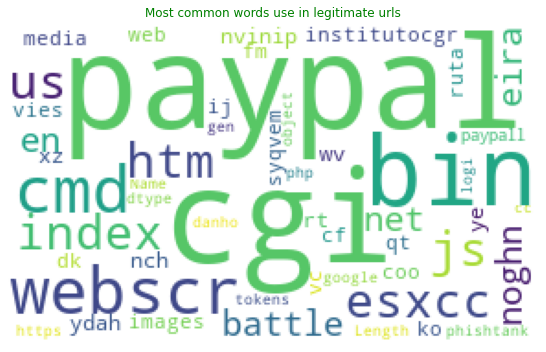

In [ ]:
common_text = str(data_legitimate)
common_mask = np.array(Image.open('/content/ger_flag.png'))
plot_wordcloud(common_text, common_mask, max_words=500, max_font_size=70, 
               title = 'Most common words use in legitimate urls', title_size=12)

In [ ]:
data_phishing = Phishing.tokens
data_phishing.reset_index(drop=True, inplace=True)

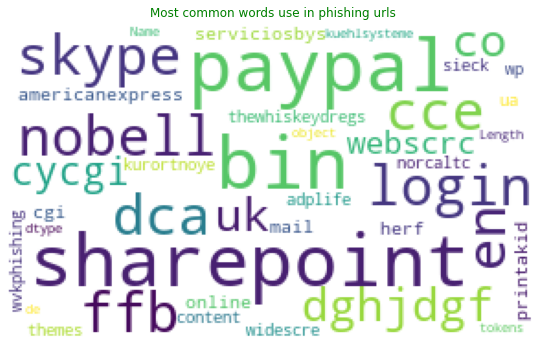

In [ ]:
common_text = str(data_phishing)
common_mask = np.array(Image.open('/content/ger_flag.png'))
plot_wordcloud(common_text, common_mask, max_words=500, max_font_size=40, 
               title = 'Most common words use in phishing urls', title_size=12)

# Vectorizing

The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer   


In [ ]:
#create one_hot encoding
cv = CountVectorizer()

In [ ]:
help(CountVectorizer())

Help on CountVectorizer in module sklearn.feature_extraction.text object:

class CountVectorizer(_VectorizerMixin, sklearn.base.BaseEstimator)
 |  CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
 |  
 |  Convert a collection of text documents to a matrix of token counts
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  --------

In [ ]:
#transform all text which we tokenize and stemed
feature = cv.fit_transform(urls.tokens) 

In [ ]:
# convert sparse matrix into array to print transformed features
feature[:12].toarray() 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 

In [ ]:
trainX, testX, trainY, testY = train_test_split(feature, urls.Label, test_size = 0.2, random_state = 0)

In [ ]:
# create lr object
model = LogisticRegression()

In [ ]:
model.fit(trainX,trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model.score(testX,testY)

0.9716539834239716

In [ ]:
Scores_model1 = {}
Scores_model1['Logistic Regression'] = np.round(model.score(testX,testY),2)

Training Accuracy : 0.9807987244965163
Testing Accuracy : 0.9716539834239716

CLASSIFICATION REPORT

              precision    recall  f1-score   support

    phishing       0.97      0.95      0.96     83404
  legitimate       0.97      0.98      0.98    134863

    accuracy                           0.97    218267
   macro avg       0.97      0.97      0.97    218267
weighted avg       0.97      0.97      0.97    218267


CONFUSION MATRIX


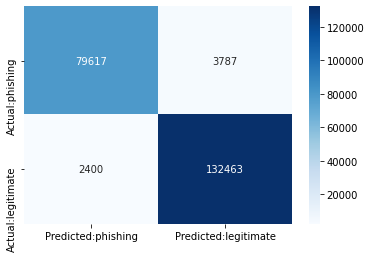

In [ ]:
print('Training Accuracy :',model.score(trainX,trainY))
print('Testing Accuracy :',model.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(model.predict(testX), testY),
            columns = ['Predicted:phishing', 'Predicted:legitimate'],
            index = ['Actual:phishing', 'Actual:legitimate'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(model.predict(testX), testY,
                            target_names =['phishing','legitimate']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="Blues")

# Pipeline
To get ideal format of dataset, data should go through different transformational steps such as encoding categorical variables, feature scaling and normalisation.
To avoid applzing all these data preprocessing twice, Once for training the model and again for the prediction of new data. It is possible to write a function and apply it to the whole model, but in order to reuse the, it should be run from the very beginning and the model should be called seprately. Scikit-learn pipelines are a tool to simplify this process: 

•	They make the workflow much easier to read and understand.

•	They enforce the implementation and order of steps in the project.

•	These in turn make the work more reproducible.



In [ ]:
pipeline_model1 = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())


In [ ]:
trainX, testX, trainY, testY = train_test_split(urls.URL, urls.Label)

In [ ]:
pipeline_model1.fit(trainX,trainY)

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<bo...mpty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                   

In [ ]:
pipeline_model1.score(testX,testY) 

0.9711509562591173

Training Accuracy : 0.9788759926695174
Testing Accuracy : 0.9711509562591173

CLASSIFICATION REPORT

              precision    recall  f1-score   support

    phishing       0.97      0.95      0.96    104415
  legitimate       0.97      0.98      0.98    168419

    accuracy                           0.97    272834
   macro avg       0.97      0.97      0.97    272834
weighted avg       0.97      0.97      0.97    272834


CONFUSION MATRIX


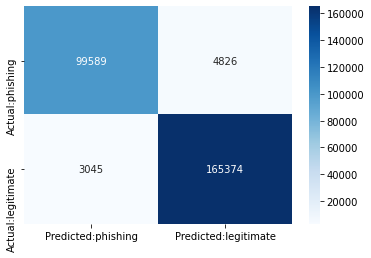

In [ ]:
print('Training Accuracy :',pipeline_model1.score(trainX,trainY))
print('Testing Accuracy :',pipeline_model1.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_model1.predict(testX), testY),
            columns = ['Predicted:phishing', 'Predicted:legitimate'],
            index = ['Actual:phishing', 'Actual:legitimate'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_model1.predict(testX), testY,
                            target_names =['phishing','legitimate']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="Blues")

# Saving the model and test it with new URLs

In [ ]:
pickle.dump(pipeline_model1,open('model.pkl','wb'))

In [ ]:
loaded_model = pickle.load(open('model.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9711509562591173


In [ ]:
predict_phishing = ['http://esprithouse.com/oefj5423.phtml?dh4BLfcclmWjcwBRrcfcJHcmc0vHvdsrscbbb4h','https://http://amasmcon.xyz/amazonhz/tb.php?v=ss1616587','https://www.mt5apps.com/pay5/F2A88E15','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_legitimate = ['https://patoghu.com/fun/game/','https://www.radio24.ilsole24ore.com/programmi/lazanzara','https://nonciclopedia.org/wiki/Pagina_principale', 'https://www.ishkar.com/']
loaded_model = pickle.load(open('model.pkl', 'rb'))
result = loaded_model.predict(predict_phishing)
result2 = loaded_model.predict(predict_legitimate)
print(result)
print("*"*50)
print(result2)

['phishing' 'phishing' 'phishing' 'phishing']
**************************************************
['legitimate' 'legitimate' 'legitimate' 'legitimate']
